## Link da base de dados no github: 
- https://github.com/Gustavocurty/VisaoComputacional.git

Estamos usando apenas a pasta ImagensVisaoComp que ja contèm todas as fotos.

In [57]:
import os
from PIL import Image, ImageFilter, ImageOps
import numpy as np
import math
from scipy.signal import convolve2d
import pillow_heif
import re
import pandas as pd
from collections import defaultdict
import cv2
import matplotlib.pyplot as plt

In [58]:
# Registrar suporte HEIF/HEIC no Pillow
pillow_heif.register_heif_opener()

file = 'ImagensVisaoComp'
augmented_folder = 'augmented_fotos'
normalized_folder = 'normalized_fotos'

# Verificar se o diretório existe
if not os.path.exists(file):
    print(f"O diretório '{file}' não existe.")
    exit()

# Verificar se a pasta augmented_fotos existe, se não, criar
if not os.path.exists(augmented_folder):
    os.makedirs(augmented_folder)

imagens = os.listdir(file)

# Filtrar apenas os arquivos de imagem
image_files = [img for img in imagens if img.lower().endswith(('.jpg', '.jpeg', '.png', '.heic'))]


## EP2.1: Data augmentation

In [59]:
def rgb2gray(image):
    return image.convert('L')

def gradient_background_addition(image):
    # Adiciona um gradiente no fundo da imagem em níveis de cinza
    width, height = image.size
    gradient = np.tile(np.linspace(0, 255, width, dtype=np.uint8), (height, 1))
    image_np = np.array(image)
    result = np.clip(image_np + gradient, 0, 255)
    return Image.fromarray(result)

def log_transform(image):
    image_np = np.array(image, dtype=np.float32) + 1  # Adicionar 1 para evitar log(0)
    c = 255 / np.log(1 + np.max(image_np))
    log_image = c * np.log(image_np)
    return Image.fromarray(np.clip(log_image, 0, 255).astype(np.uint8))

def exp_transform(image):
    # Transformação exponencial e normalização
    image = np.float32(image) / 255.0
    exp_image = np.exp(image)
    exp_image = cv2.normalize(exp_image, None, 0, 255, cv2.NORM_MINMAX)
    return Image.fromarray(np.uint8(exp_image))

def mean_filter(image, kernel_size=3):
    return image.filter(ImageFilter.Kernel((kernel_size, kernel_size), [1/(kernel_size**2)]*kernel_size**2))

# Processar cada imagem
for img_file in image_files:
    # Carregar a imagem
    img_path = os.path.join(file, img_file)
    image = Image.open(img_path)

    # Converter para níveis de cinza e salvar no originalGrayDataset
    gray_image = rgb2gray(image)
    gray_path = os.path.join(augmented_folder, f'gray_{img_file}')
    gray_image.save(gray_path)

    # Aplicar e salvar cada função de data augmentation
    transformations = {
        'gradient': gradient_background_addition,
        'log': log_transform,
        'exp': exp_transform,
        'mean': lambda img: mean_filter(img, kernel_size=3)
    }

    for name, func in transformations.items():
        augmented_image = func(gray_image)
        augmented_path = os.path.join(augmented_folder, f'{name}_{img_file}')
        augmented_image.save(augmented_path)

print("Data augmentation concluído e imagens salvas em", augmented_folder)


Data augmentation concluído e imagens salvas em augmented_fotos


In [62]:
# Função para extrair partes do nome da imagem
def split_name(image_name):
    name_parts = image_name.split('-')
    if len(name_parts) < 4:
        print(f"Nome da imagem '{image_name}' não está no formato esperado.")
        return None
    object_type = name_parts[0].strip()
    object_name = name_parts[1].strip()
    day_or_night = name_parts[2].strip()
    environment = name_parts[3].strip()
    background = name_parts[4].strip().split('.')[0]
    return object_type, object_name, day_or_night, environment, background

# Tabela detalhada de cada imagem
def create_image_table(image_files, folder_path): 
    data = {
        'Nome do objeto': [],
        'Dia/Noite': [],
        'Ambiente': [],
        'Fundo': [],
        'Tamanho (KB)': [],
        'Dimensão (px)': [],
    }
    
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        
        parsed_data = split_name(image_file)
        if parsed_data is None:
            continue
        
        object_type, object_name, day_or_night, environment, background = parsed_data

        try:
            image = Image.open(image_path)
            size_kb = os.path.getsize(image_path) / 1024
            width, height = image.size
            dimension = f"{width}x{height}"

            data['Nome do objeto'].append(object_name)
            data['Dia/Noite'].append(day_or_night)
            data['Ambiente'].append(environment)
            data['Fundo'].append(background)
            data['Tamanho (KB)'].append(int(size_kb)) 
            data['Dimensão (px)'].append(dimension)
            
        except Exception as e:
            print(f"Erro ao processar a imagem '{image_file}': {e}")
    
    df = pd.DataFrame(data)
    df.to_csv('tabela_imagens.csv', index=False)
    return df

# Tabela sumária global
def tabela_global_sumaria(image_files, folder_path):
    data = {
        'Nomes dos objetos': [],
        'Número de classes': 0,
        'Número de Imagens': 0,
        'Tamanho da base (KB)': 0,
        'Resolução das imagens': None,
    }
    
    selected_object = set()
    total_size_kb = 0

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        
        parsed_data = split_name(image_file)
        if parsed_data is None:
            continue
        
        object_type, object_name, day_or_night, environment, background = parsed_data
        
        selected_object.add(object_name)
        
        try:
            image = Image.open(image_path)
            size_kb = os.path.getsize(image_path) / 1024
            total_size_kb += size_kb

            if data['Resolução das imagens'] is None:
                width, height = image.size
                dimension = f"{width}x{height}"
                data['Resolução das imagens'] = dimension

        except Exception as e:
            print(f"Erro ao processar a imagem '{image_file}': {e}")
            continue

    data['Nomes dos objetos'] = list(selected_object)
    data['Número de classes'] = len(selected_object)
    data['Número de Imagens'] = len(image_files)
    data['Tamanho da base (KB)'] = int(total_size_kb)

    df = pd.DataFrame([data])
    df.to_csv('tabela_global_sumaria.csv', index=False)
    return df

# Tabela detalhada por classe
def tabela_detalhada_classe(image_files):
    data = defaultdict(lambda: {
        'Qntd de Objetos': 0,
        'Variações de fundo': set(),
        'Variações de iluminação': set(),
        'Total de amostras': 0,
    })

    for image_file in image_files:
        parsed_data = split_name(image_file)
        if parsed_data is None:
            continue
        
        object_type, object_name, day_or_night, environment, background = parsed_data
        
        data[object_name]['Qntd de Objetos'] += 1  
        data[object_name]['Variações de fundo'].add(background)  
        data[object_name]['Variações de iluminação'].add(day_or_night)  
        data[object_name]['Total de amostras'] += 1  

    table_data = []
    for object_name, stats in data.items():
        table_data.append({
            'Nome do objeto': object_name,
            'Qntd de Objetos': stats['Qntd de Objetos'],
            'Variações de fundo': ', '.join(stats['Variações de fundo']),
            'Variações de iluminação': ', '.join(stats['Variações de iluminação']),
            'Total de amostras': stats['Total de amostras'],
        })
    
    df = pd.DataFrame(table_data)
    df.to_csv('tabela_detalhada_classe.csv', index=False)
    return df

# Executando e exibindo as tabelas
image_files = os.listdir(augmented_folder)

print('Tabela Global Sumária')
df_global = tabela_global_sumaria(image_files, augmented_folder)
print(df_global)

print('\nTabela Detalhada por Classe')
df_detalhada = tabela_detalhada_classe(image_files)
print(df_detalhada)


Tabela Global Sumária


IndexError: list index out of range

## EP2.2: Normalização e análise da variação das classes


Análise para o dataset: Original
Protótipo médio (exibido como imagem):


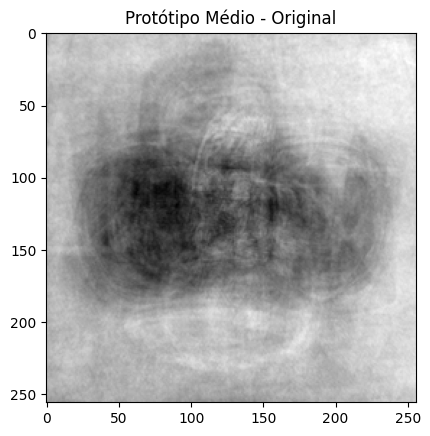

Histograma médio:


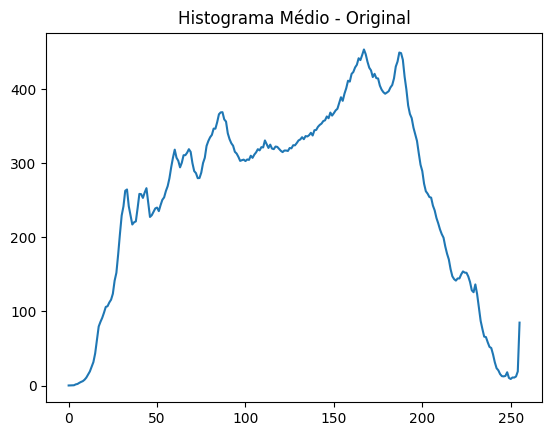

Variância do histograma:


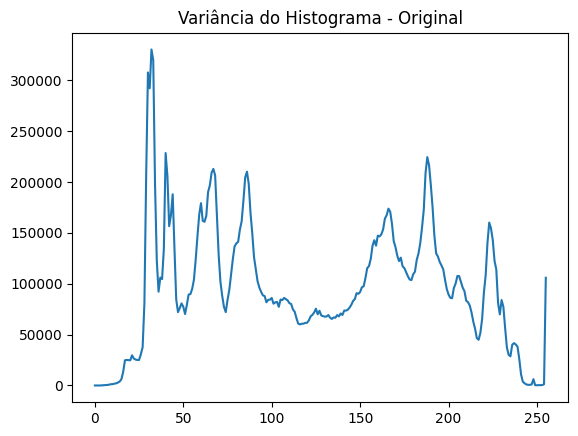


Análise para o dataset: Augmented
Protótipo médio (exibido como imagem):


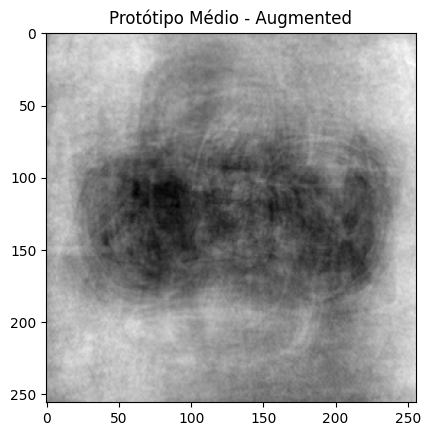

Histograma médio:


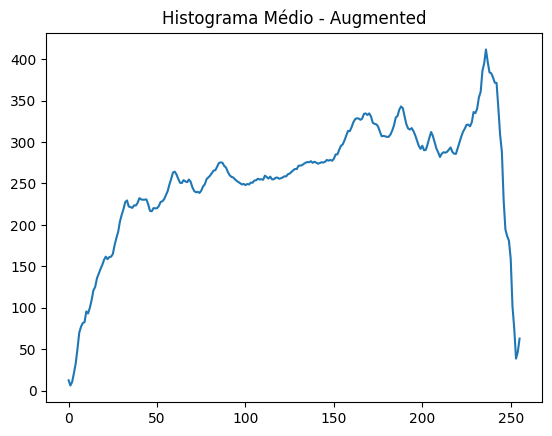

Variância do histograma:


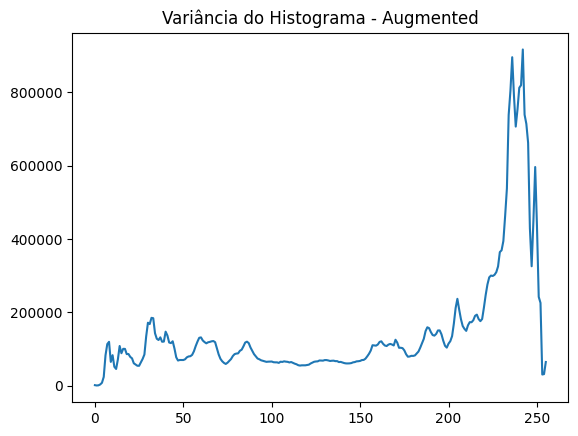


Análise para o dataset: Normalized
Protótipo médio (exibido como imagem):


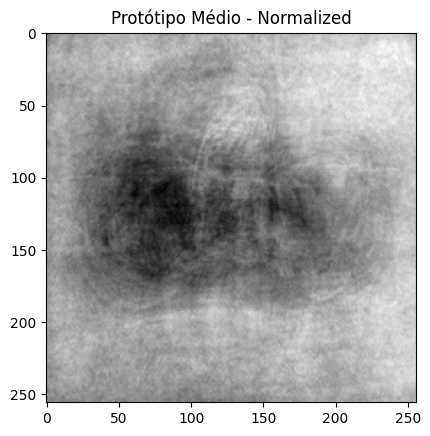

Histograma médio:


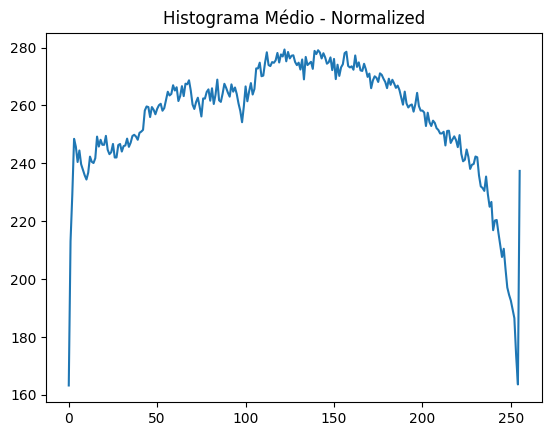

Variância do histograma:


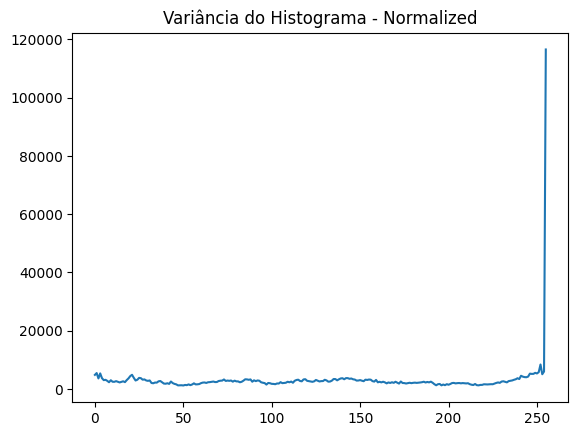

In [61]:
# Função de equalização de histograma
def histogram_equalization(image):
    return ImageOps.equalize(image)

# Aplicar equalização de histograma ao originalGrayDataset para criar normalizedDataset
for img_file in os.listdir(file):
    if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.heic')):
        img_path = os.path.join(file, img_file)
        image = Image.open(img_path).convert('L')  # Converter para grayscale
        normalized_image = histogram_equalization(image)
        normalized_image.save(os.path.join(normalized_folder, img_file))

# Funções de análise de dados
def calculate_prototype(images):
    # Protótipo médio: média de todas as imagens de uma classe
    return np.mean(images, axis=0)

def calculate_average_histogram(images):
    # Histograma médio: média dos histogramas de todas as imagens de uma classe
    histograms = [np.histogram(img, bins=256, range=(0, 255))[0] for img in images]
    return np.mean(histograms, axis=0)

def calculate_histogram_variance(images):
    # Variância do histograma: variância dos histogramas de todas as imagens de uma classe
    histograms = [np.histogram(img, bins=256, range=(0, 255))[0] for img in images]
    return np.var(histograms, axis=0)

# Função para carregar imagens de um diretório e converter para numpy arrays
def load_images_from_folder(folder, target_size=(256, 256)):
    images = []
    for img_file in os.listdir(folder):
        if img_file.endswith(('.png', '.jpg', '.jpeg', '.heic')):
            image_path = os.path.join(folder, img_file)
            try:
                image = Image.open(image_path).convert('L')  # Converte para escala de cinza
                image = image.resize(target_size)  # Redimensiona a imagem
                images.append(np.array(image))
            except Exception as e:
                print(f"Erro ao carregar a imagem {img_file}: {e}")
    return np.array(images)

# Carregar datasets
original_images = load_images_from_folder(file)
augmented_images = load_images_from_folder(augmented_folder)
normalized_images = load_images_from_folder(normalized_folder)

# Calcular e mostrar análise para cada dataset
datasets = {
    'Original': original_images,
    'Augmented': augmented_images,
    'Normalized': normalized_images
}

for name, images in datasets.items():
    prototype = calculate_prototype(images)
    avg_histogram = calculate_average_histogram(images)
    hist_variance = calculate_histogram_variance(images)
    
    # Exibir resultados
    print(f"\nAnálise para o dataset: {name}")
    print("Protótipo médio (exibido como imagem):")
    plt.imshow(prototype, cmap='gray')
    plt.title(f'Protótipo Médio - {name}')
    plt.show()
    
    print("Histograma médio:")
    plt.plot(avg_histogram)
    plt.title(f'Histograma Médio - {name}')
    plt.show()
    
    print("Variância do histograma:")
    plt.plot(hist_variance)
    plt.title(f'Variância do Histograma - {name}')
    plt.show()